<a href="https://colab.research.google.com/github/chineidu/Deep-Learning-With-Pytorch/blob/main/notebook/08_FFN_Autoencoders/03_CPUs_vs_GPUs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPU Vs GPU

```text
CPU
---
- Designed for sequential processing.
Used for ML tasks that don't require a lot of parallel processing power. e.g. data preprocwssing, feature extraction and model evaluation.
- It's cheaper than GPUs.


GPU
---
- Designed for parallel processing.
- Used for ML tasks such as training neural networks.
- It's more expensive than CPUs.
```

In [1]:
# Built-in library
import logging
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Configure the backend
import matplotlib_inline.backend_inline

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 2_000

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

# Custom import
# from src.utilities import (
#     set_up_logger,
#     create_iris_data,
#     create_qwerties_data,
#     smooth,
# )
# from src.data_manager import (
#     load_data,
#     create_data_loader,
#     split_into_train_n_validation,
# )
# from src.preprocessor import Standardizer, Normalizer


# Black code formatter (Optional)
# %load_ext lab_black
# # auto reload imports
# %load_ext autoreload
# %autoreload 2

## Select the processor device

```text
Note: To run models on a GPU you must select from the menu:
  -> Runtime
     -> Change runtime type
       -> Hardware accelerator
         -> GPU

```

In [2]:
# Use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# Build A Simple Model
net = nn.Sequential(
    nn.Linear(20, 100),
    nn.ReLU(),
    nn.Linear(100, 500),
    nn.ReLU(),
    nn.Linear(500, 30),
    nn.ReLU(),
    nn.Linear(30, 2)
      )

net

Sequential(
  (0): Linear(in_features=20, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=500, bias=True)
  (3): ReLU()
  (4): Linear(in_features=500, out_features=30, bias=True)
  (5): ReLU()
  (6): Linear(in_features=30, out_features=2, bias=True)
)

In [4]:
# Create the test data
X = torch.randn((1000, 20))
y = torch.randint(low=0, high=2, size=(1, 1000))

In [5]:
# Send the model and the data to the GPU
net.to(device)

# data
X = X.to(device)
y = y.to(device)

In [6]:
device

device(type='cuda', index=0)

In [7]:
# You can also create data directly on the GPU
X_G = torch.randn((1000,20), device=device)
X_C = torch.randn((1000,20), device='cpu')

print(X.device)
print(X_G.device)
print(X_C.device)

cuda:0
cuda:0
cpu


In [8]:
# Make Predictions
y_pred = net(X)

In [9]:
y_pred.device

device(type='cuda', index=0)

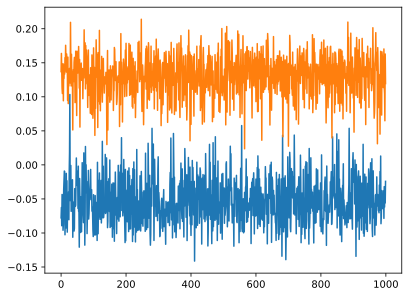

In [10]:
# Plot the data. The data has to be sent to the CPU before it can be plotted.
plt.plot(y_pred.detach().cpu());

## To Do

```python
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# Create train/test groups using DataLoader
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


# create a class for the model
def createTheMNISTNet(nUnits,nLayers):

  class mnistNet(nn.Module):
    def __init__(self,nUnits,nLayers):
      super().__init__()

      # create dictionary to store the layers
      self.layers = nn.ModuleDict()
      self.nLayers = nLayers

      ### input layer
      self.layers['input'] = nn.Linear(784,nUnits)

      ### hidden layers
      for i in range(nLayers):
        self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)

      ### output layer
      self.layers['output'] = nn.Linear(nUnits,10)



    # forward pass
    def forward(self,x):
      # input layer
      x = self.layers['input'](x)

      # hidden layers
      for i in range(self.nLayers):
        x = F.relu( self.layers[f'hidden{i}'](x) )

      # return output layer
      x = self.layers['output'](x)
      return F.log_softmax(x,dim=1)

  # create the model instance
  net = mnistNet(nUnits,nLayers)

  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

# Generate an instance of the model and confirm that it returns the expected network.
nUnitsPerLayer = 12
nLayers = 4
net = createTheMNISTNet(nUnitsPerLayer,nLayers)


# a function that trains the model

def function2trainTheModel(nUnits,nLayers):

  # number of epochs
  numepochs = 60

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet(nUnits,nLayers)

  # New!
  net.to(device)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # New!
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # New! bring outputs back
      yHat = yHat.cpu()
      y = y.cpu()

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # New!
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # New! bring outputs back
    yHat = yHat.cpu()
    y = y.cpu()

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# test the model once to make sure it works
trainAcc,testAcc,losses,net = function2trainTheModel(65,2)

### run the experiment!
#  CPU took 30 mins
#  GPU takes 13 mins

# define the model parameters
numlayers = range(1,4)           # number of hidden layers
numunits  = np.arange(50,251,50) # units per hidden layer

# initialize output matrices
accuracies  = np.zeros((2,len(numunits),len(numlayers)))

# start the experiment!
for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):

    # create and train a fresh model
    trainAcc,testAcc,losses,net = function2trainTheModel(numunits[unitidx],numlayers[layeridx])

    # store the results (average of final 5 epochs)
    accuracies[0,unitidx,layeridx] = np.mean(trainAcc[-5:])
    accuracies[1,unitidx,layeridx] = np.mean(testAcc[-5:])

    # print a friendly status message
    print(f'Finished units {unitidx+1}/{len(numunits)} and layers {layeridx+1}/{len(numlayers)}')

# show accuracy as a function of model depth
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(numunits,accuracies[0,:,:],'o-',markerfacecolor='w',markersize=9)
ax[1].plot(numunits,accuracies[1,:,:],'o-',markerfacecolor='w',markersize=9)

for i in range(2):
  ax[i].legend(numlayers)
  ax[i].set_ylabel('Accuracy')
  ax[i].set_xlabel('Number of hidden units')
  ax[i].set_title([ 'Train' if i==0 else 'Test' ][0])

plt.show()

```